In [1]:
directory = '/home/mgutierrez/Desktop/Autoencoders/Data4'


import forward_inverse_problem as fip
import filtering
#import data_load as dl
import precompute_matrix as pre_m
import metrics
import freq_phase_analysis as freq_pha
import sys,os
from scipy.io import loadmat
import data_load as dl
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import os
import time
import tensorflow as tf
import keras
from keras import models, layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.utils import shuffle
from itertools import product
from tools_tikhonov import *
from tensorflow.keras import datasets, layers, models, losses, Model
import pickle
import sys 
from numpy import reshape
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import cv2
import glob
from PIL import Image
import matplotlib.image
import time
import random
import pandas as pd
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.io import savemat
import forward_inverse_problem as fip

#


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
    
start = time.time()


Num GPUs: 1


2023-05-23 11:45:55.320244: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-23 11:45:55.525158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-23 11:45:55.525497: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
all_model_names = []
    
for subdir, dirs, files in os.walk(directory):
    print(subdir, directory, files)

    if (subdir != directory):
        model_name = subdir.split("/")[-1]
        all_model_names.append(model_name)
       
all_model_names=sorted(all_model_names)
print (all_model_names)
print(len(all_model_names), 'Models')
    

/home/mgutierrez/Desktop/Autoencoders/Data4/ /home/mgutierrez/Desktop/Autoencoders/Data4/ []
/home/mgutierrez/Desktop/Autoencoders/Data4/LA_LSPV_150113 /home/mgutierrez/Desktop/Autoencoders/Data4/ ['BSPs.mat', 'driver_position.mat', 'labels_video.mp4', 'EGMs.mat']
/home/mgutierrez/Desktop/Autoencoders/Data4/Simulation_01_200316_001_  1 /home/mgutierrez/Desktop/Autoencoders/Data4/ ['EGMs.mat']
/home/mgutierrez/Desktop/Autoencoders/Data4/RA_RAFW_SAF_140730 /home/mgutierrez/Desktop/Autoencoders/Data4/ ['BSPs.mat', 'driver_position.mat', 'labels_video.mp4', 'EGMs.mat']
/home/mgutierrez/Desktop/Autoencoders/Data4/Simulation_01_190619_001_007 /home/mgutierrez/Desktop/Autoencoders/Data4/ ['EGMs.mat']
/home/mgutierrez/Desktop/Autoencoders/Data4/Simulation_01_190619_001_005 /home/mgutierrez/Desktop/Autoencoders/Data4/ ['EGMs.mat']
/home/mgutierrez/Desktop/Autoencoders/Data4/Simulation_01_190619_001_009 /home/mgutierrez/Desktop/Autoencoders/Data4/ ['EGMs.mat']
/home/mgutierrez/Desktop/Autoencode

In [4]:

n_classes = 3 #1: Rotor/no rotor ; 2: RA/LA/No rotor (2 classes) ; 3: 7 regions (3 classes) + no rotor (8 classes)

X_1channel,Y,Y_model, egm_tensor, length_list, AF_models, all_model_names, transfer_matrices=load_data(data_type='Flat', n_classes=n_classes, subsampling= True, fs_sub=500, norm=False, SR=True, SNR=20)

['LA_LSPV_150113', 'LA_PLAW_140711_arm', 'RA_RAFW_SAF_140730', 'Simulation_01_190619_001_002', 'Simulation_01_190619_001_005', 'Simulation_01_190619_001_007', 'Simulation_01_190619_001_009', 'Simulation_01_200316_001_  1']


/home/mgutierrez/Desktop/Tikhonov/Tikhonov/tools_tikhonov.py:250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(X),np.array(Y),np.array(Y_model),np.array(egm_tensor), length_list, AF_models, all_model_names, transfer_matrices


In [5]:
X_1channel[0].shape

(3970,)

In [7]:
atrial_model=0
order=0
x_hat_array=[]
x_array=[]

for model in range(1, len(all_model_names)):
    
    print('Calculando modelo', all_model_names[model])
    pos_model = np.where(np.array(AF_models)==model)
    pos_unique=np.unique(Y_model[pos_model])[0] #Select only the first torso
    y = np.array(X_1channel[np.where(Y_model==pos_unique)])
    #y = np.array(X_1channel[np.where(Y_model==model)])
    x = np.array(egm_tensor[np.where(Y_model==pos_unique)])
    y = np.vstack(y).T

    A = np.array(transfer_matrices[0][0]) #Only one torso
    AA,L,LL = pre_m.precompute_matrix(A, atrial_model, order)
    # Classical Tikhonov-based inverse problem approach.
    #x_hat_tikh, lambda_opt_tikh = classical_tikhonov_noiter(A, AA, L, LL, y, 50)
    #x_hat,lambda_opt_list,magnitude_terms_list,error_terms_list,max_lcurve_list = fip.classical_tikhonov_noiter(A, AA, L, LL, y, 500)
    x_hat,lambda_opt,magnitude_term,error_term,maxcurve_index= fip.classical_tikhonov_noiter_global(A, AA, L, LL, y)
    DF_tikh, sig_k_tikh, phase_tikh = freq_pha.kuklik_DF_phase(x_hat,fs)

    # Classical Tikhonov-based inverse problem metrics
    #RDMSt_tikh, mRDMSt_tikh, stdRDMSt_tikh = metrics.RDMS_calc(x,x_hat)
    #CCt_tikh, mCCt_tikh, stdCCt_tikh = metrics.CC_calc(x,x_hat)
    x_hat=x_hat.T

    x_hat_array.append(x_hat)
    x_array.append(x)

    break
np.savez('x_hat_array.npz', x_hat_array)
np.savez('x_array.npz', x_array)





Calculando modelo LA_PLAW_140711_arm
Classical Tikhonov method (full lambda sampling method). Number of tested lambda values: 1/128
Classical Tikhonov method (full lambda sampling method). Number of tested lambda values: 2/128
Classical Tikhonov method (full lambda sampling method). Number of tested lambda values: 3/128
Classical Tikhonov method (full lambda sampling method). Number of tested lambda values: 4/128
Classical Tikhonov method (full lambda sampling method). Number of tested lambda values: 5/128
Classical Tikhonov method (full lambda sampling method). Number of tested lambda values: 6/128
Classical Tikhonov method (full lambda sampling method). Number of tested lambda values: 7/128
Classical Tikhonov method (full lambda sampling method). Number of tested lambda values: 8/128
Classical Tikhonov method (full lambda sampling method). Number of tested lambda values: 9/128
Classical Tikhonov method (full lambda sampling method). Number of tested lambda values: 10/128
Classical Ti

/home/mgutierrez/Desktop/Tikhonov/Tikhonov/freq_phase_analysis.py:106: RuntimeWarning: divide by zero encountered in true_divide
  invf = np.divide(1,f); pxx = pxx[np.logical_and(invf>=period_min,invf<=period_max)];


Kuklik signal recomposition. Node: 0
Kuklik signal recomposition. Node: 1
Kuklik signal recomposition. Node: 2
Kuklik signal recomposition. Node: 3
Kuklik signal recomposition. Node: 4
Kuklik signal recomposition. Node: 5
Kuklik signal recomposition. Node: 6
Kuklik signal recomposition. Node: 7
Kuklik signal recomposition. Node: 8
Kuklik signal recomposition. Node: 9
Kuklik signal recomposition. Node: 10
Kuklik signal recomposition. Node: 11
Kuklik signal recomposition. Node: 12
Kuklik signal recomposition. Node: 13
Kuklik signal recomposition. Node: 14
Kuklik signal recomposition. Node: 15
Kuklik signal recomposition. Node: 16
Kuklik signal recomposition. Node: 17
Kuklik signal recomposition. Node: 18
Kuklik signal recomposition. Node: 19
Kuklik signal recomposition. Node: 20
Kuklik signal recomposition. Node: 21
Kuklik signal recomposition. Node: 22
Kuklik signal recomposition. Node: 23
Kuklik signal recomposition. Node: 24
Kuklik signal recomposition. Node: 25
Kuklik signal recompos

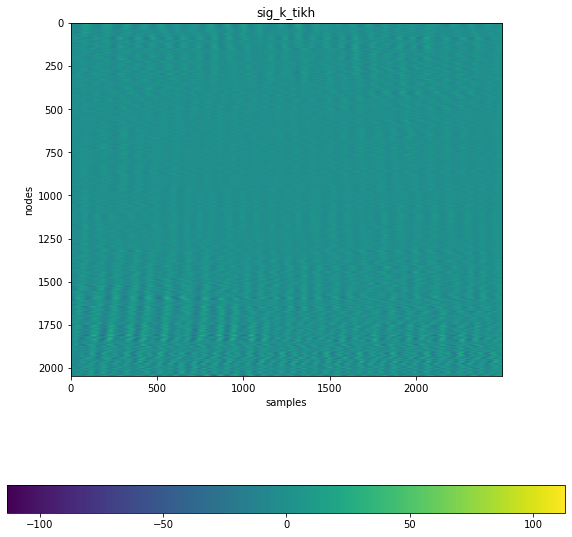

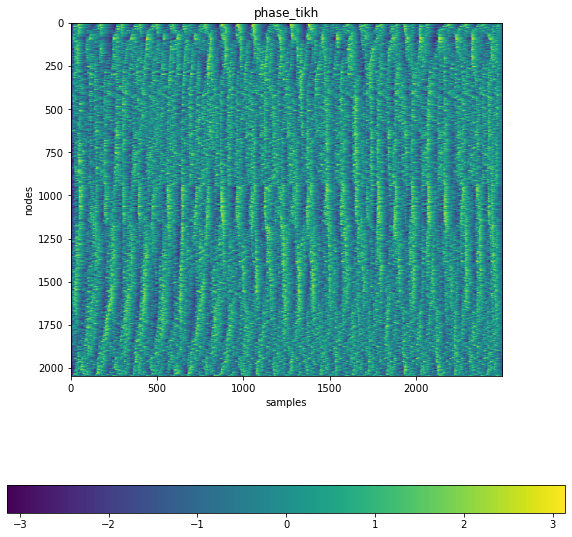

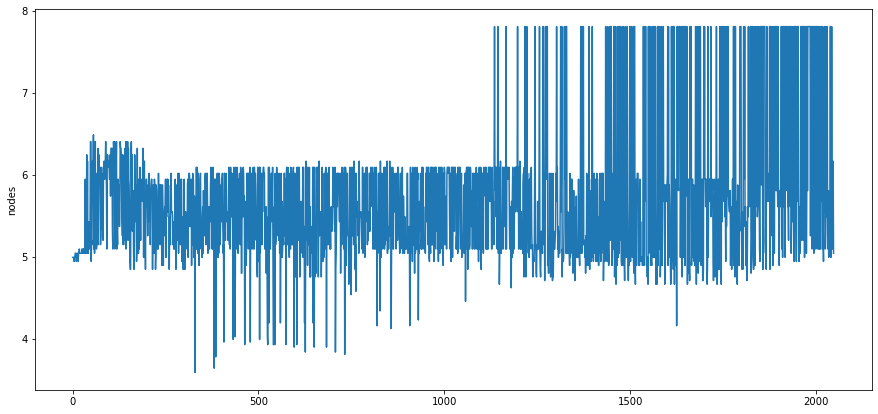

In [15]:
 #DF_tikh, sig_k_tikh, phase_tikh
plt.figure(figsize=(10, 10))
plt.imshow(sig_k_tikh)
plt.colorbar(orientation="horizontal", pad=0.2)
plt.ylabel('nodes')
plt.xlabel('samples')
plt.title('sig_k_tikh')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(phase_tikh)
plt.colorbar(orientation="horizontal", pad=0.2)
plt.ylabel('nodes')
plt.xlabel('samples')
plt.title('phase_tikh')
plt.show()

plt.figure(figsize=(15, 7))
plt.plot(DF_tikh)
plt.ylabel('nodes')
plt.show()

mdic = {"phase_tikh": phase_tikh, "sig_k_tikh": sig_k_tikh, "DF_tikh": DF_tikh }

savemat("DFMapping.mat", mdic)





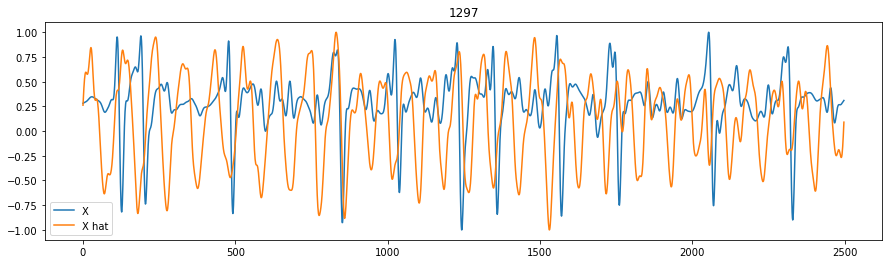

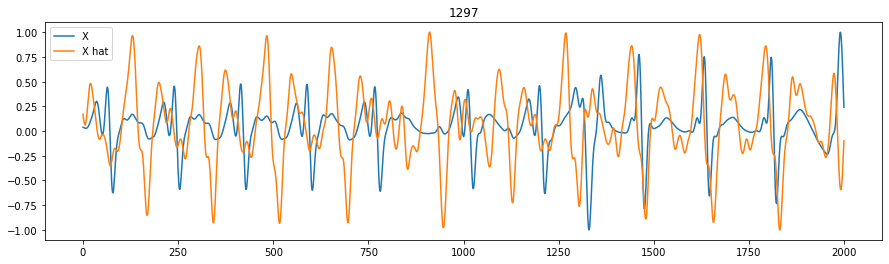

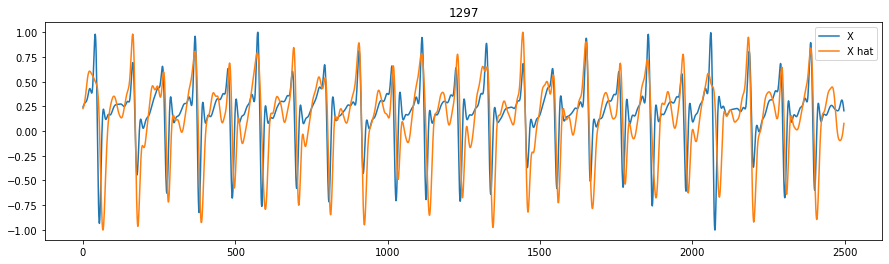

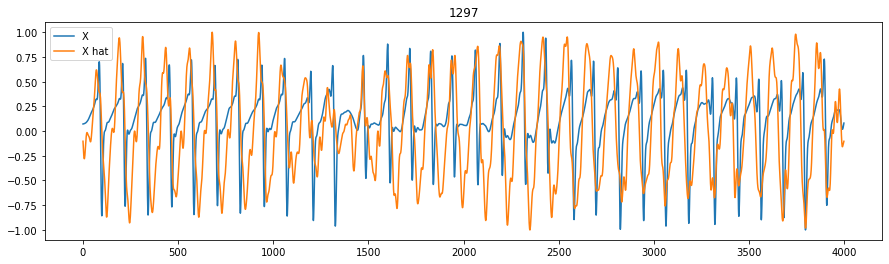

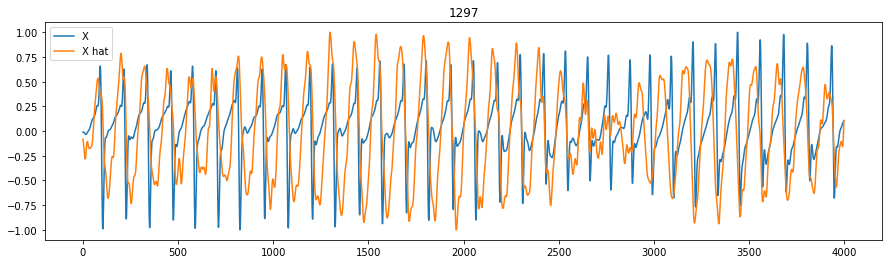

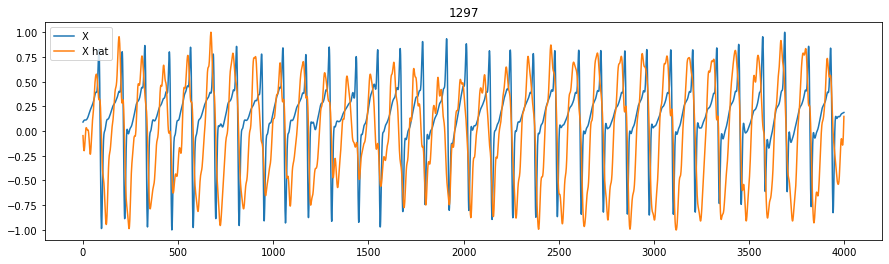

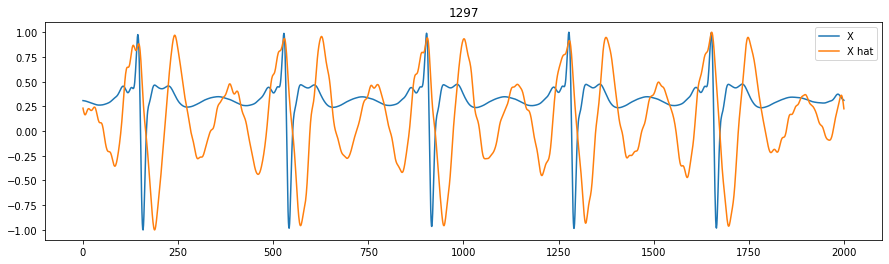

In [ ]:
node=random.randrange(0, 2048, 1)

for model_i in range(0, len(x_hat_array)):

    x_hat = x_hat_array[model_i]#, :, :]
    x = x_array[model_i]#, :, :]

    x_hat = normalize_array(x_hat, 1, -1, 0)
    x = normalize_array(x, 1, -1, 0)

    plt.figure(figsize=(15, 4))
    #plt.subplot(len(x_hat_array), 1, model_i)
    plt.plot(x[:, node], label= 'X')
    plt.plot(x_hat[:, node], label= 'X hat')
    plt.legend()
    plt.title(node)
    plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import math
rmse_list=[]
corr_list=[]
for model_i in range(0, len(x_hat_array)):

    x_hat = x_hat_array[model_i]#, :, :]
    x = x_array[model_i]#, :, :]
    
    #normalize
    x_hat = normalize_array(x_hat, 1, -1, 0)
    x = normalize_array(x, 1, -1, 0)

    #rmse
    rmse_list_node=[]

    for node in range(0, x_hat.shape[1]):
        #RMSE
        MSE = mean_squared_error(x_hat[:, node], x[:, node])
        RMSE = math.sqrt(MSE)
        rmse_list_node.append(RMSE)

    rmse_list.extend([rmse_list_node])

    #Corr
    corr=corr_pearson_cols(x_hat, x)
    corr_list.extend([corr])



rmse_array=np.array(rmse_list)
corr_array=np.array(corr_list)

NameError: name 'pearsonr' is not defined

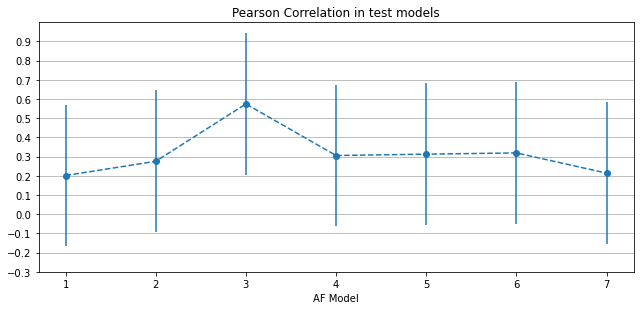

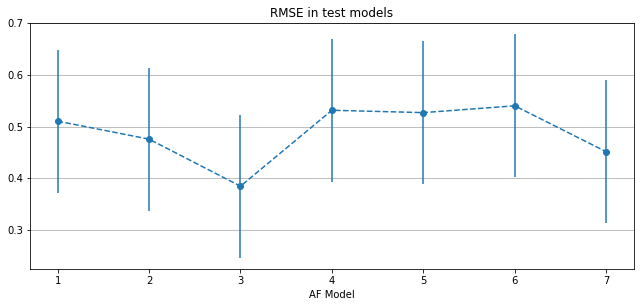

In [ ]:
rmse_mean =np.mean(rmse_array, axis=1)
rmse_std=np.std(rmse_array)
corr_mean=np.mean(corr_array, axis=1)
corr_std=np.std(corr_array)

#Labels for plotting
labels= np.arange(0, len(corr_array), 1)


x_pos = np.arange(len(labels))
xaxis = np.linspace(1,len(labels),len(labels))

# Corr
plt.figure(figsize=(9, 4))
#fig, ax = plt.subplots()
plt.errorbar(xaxis, corr_mean,
       yerr=corr_std,
       fmt='--o', label='Test')
plt.yticks(np.arange(-0.3, 1, 0.1))
#ax.set_xticks(x_pos)
#plt.xticks(rotation=90)
#ax.set_xticklabels(labels)
plt.grid(axis='y', linestyle='-')

plt.tight_layout()
plt.xlabel('AF Model')
plt.title('Pearson Correlation in test models')
plt.show()




# RMSE
plt.figure(figsize=(9, 4))
#fig, ax = plt.subplots()
plt.errorbar(xaxis, rmse_mean,
       yerr=rmse_std,
       fmt='--o')
plt.yticks(np.arange(0.3, 0.8, 0.1))
#ax.set_xticks(x_pos)
#plt.xticks(rotation=90)
#ax.set_xticklabels(labels)
plt.grid(axis='y', linestyle='-')

plt.tight_layout()
plt.xlabel('AF Model')
plt.title('RMSE in test models')
plt.show()



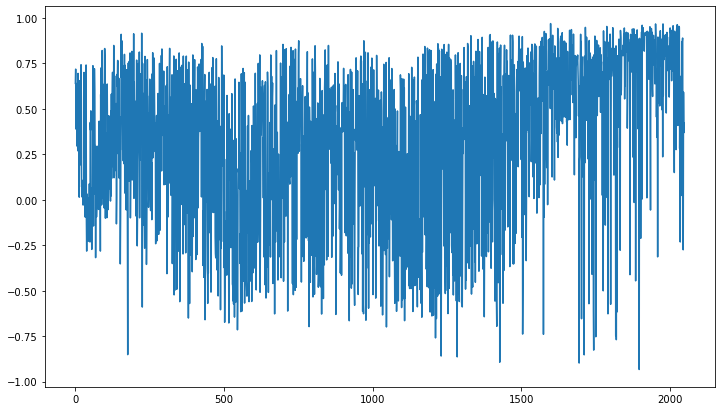

In [ ]:
correlation_nodes=corr_spearman_cols(x_hat, x)
plt.figure(figsize=(12, 7))
plt.plot(correlation_nodes)
plt.show()

